In [9]:
import pandas as pd

RANDOM_SEED = 42

# 1. Load the data into a pandas data frame.
df = pd.read_csv('Youtube05-Shakira.csv')

# 2. Carry out some basic data exploration and present your results. 
print("----------------------------")
print("Shape: ", df.shape)
print("----------------------------")
print("Columns: ", df.columns.tolist())

df = df.drop(['COMMENT_ID', 'DATE', 'AUTHOR'], axis=1)

import re 
# Data Preprocessing Function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

# Apply preprocessing to the content column
df['CONTENT'] = df['CONTENT'].apply(preprocess_text)


# 2. Carry out some basic data exploration and present your results. 
print("----------------------------")
print("Shape: ", df.shape)
print("----------------------------")
print("Columns: ", df.columns.tolist())
print("----------------------------")
print("Data Types:\n\n",df.dtypes)
print("----------------------------")
print("Missing values:\n\n", df.isnull().sum())
print("----------------------------")
print("Unique values:\n\n", df.nunique())

----------------------------
Shape:  (370, 5)
----------------------------
Columns:  ['COMMENT_ID', 'AUTHOR', 'DATE', 'CONTENT', 'CLASS']
----------------------------
Shape:  (370, 2)
----------------------------
Columns:  ['CONTENT', 'CLASS']
----------------------------
Data Types:

 CONTENT    object
CLASS       int64
dtype: object
----------------------------
Missing values:

 CONTENT    0
CLASS      0
dtype: int64
----------------------------
Unique values:

 CONTENT    316
CLASS        2
dtype: int64


----------------------------
New shape:  (370, 1291)
Feature names:  ['025' '0687119038' '10' ... 'youtubers' 'zealous' 'zonepacom']


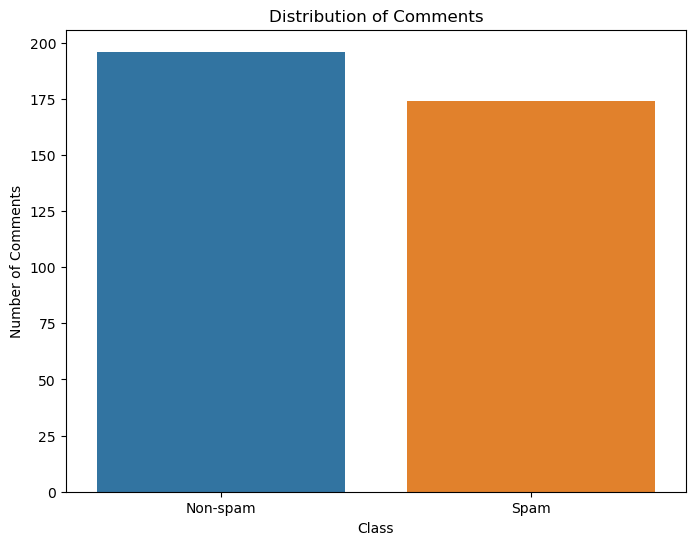

In [10]:
#import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

# 3. Using nltk toolkit classes and methods prepare the data for model building, refer to the third lab tutorial in module 11 (Building a Category text predictor ). Use count_vectorizer.fit_transform()
#nltk.download('punkt')
count_vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
dtm = count_vectorizer.fit_transform(df['CONTENT'])

# 4. Present highlights of the output (initial features) such as the new shape of the data and any other useful information before proceeding.
print("----------------------------")
print("New shape: ", dtm.shape)
print("Feature names: ", count_vectorizer.get_feature_names_out())


# Data distribution 
import matplotlib.pyplot as plt
import seaborn as sns

class_counts = df['CLASS'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Comments')
plt.xlabel('Class')
plt.ylabel('Number of Comments')
plt.xticks(ticks=[0, 1], labels=['Non-spam', 'Spam']) 
plt.show()

----------------------------
TF-IDF Matrix Shape:  (370, 1291)


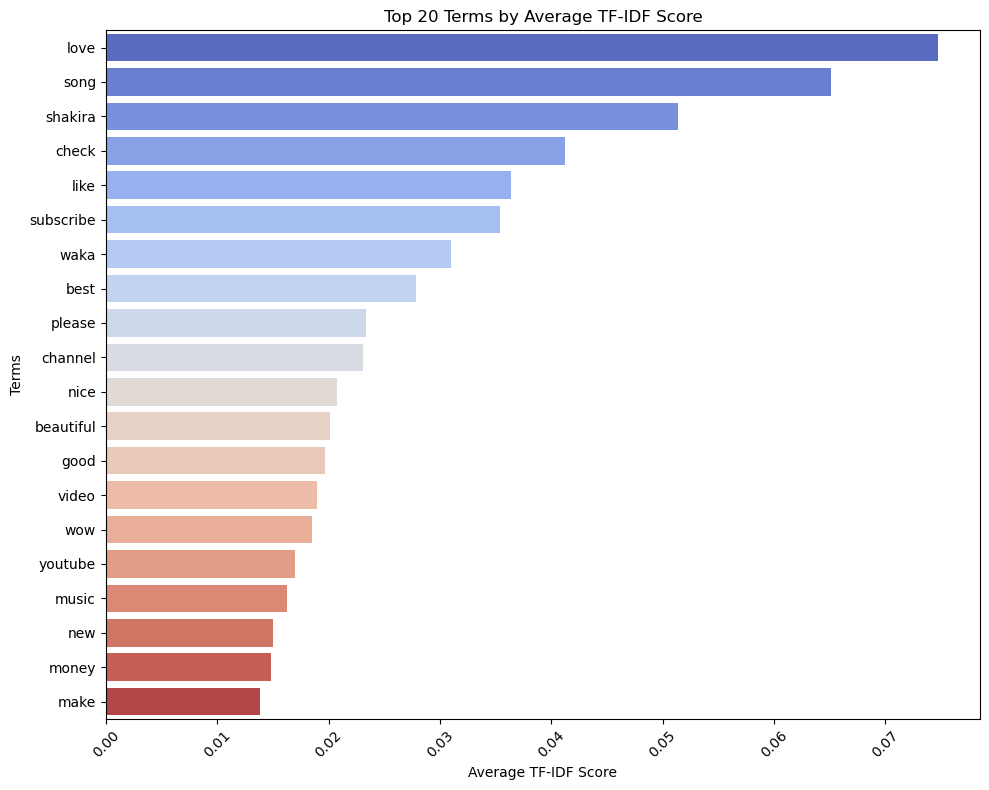

In [11]:
#Part 3 - Model training
from sklearn.feature_extraction.text import TfidfTransformer

# 5. Downscale the transformed data using tf-idf and again present highlights of the output (final features) such as the new shape of the data and any other useful information before proceeding.
tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(dtm)
print("----------------------------")
print("TF-IDF Matrix Shape: ", tfidf.shape)

import numpy as np

tfidf_df = pd.DataFrame(tfidf.toarray(), columns=count_vectorizer.get_feature_names_out())
avg_tfidf = tfidf_df.mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(10,8))
sns.barplot(x=avg_tfidf.values, y=avg_tfidf.index, palette='coolwarm')
plt.title('Top 20 Terms by Average TF-IDF Score')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Terms')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# 6. Use pandas.sample to shuffle the dataset, set frac =1
df_shuffled = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# 7. Using pandas split your dataset into 75% for training and 25% for testing, make sure to separate the class from the feature(s). (Do not use test_train_ split)
train_size = int(0.75 * len(df_shuffled))
train_df = df_shuffled[:train_size]
test_df = df_shuffled[train_size:]

x_train = train_df['CONTENT']
y_train = train_df['CLASS']
x_test = test_df['CONTENT']
y_test = test_df['CLASS']

In [13]:
# 8. Fit the training data into a Naive Bayes classifier.

from sklearn.naive_bayes import MultinomialNB

x_train_counts = count_vectorizer.fit_transform(x_train)
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
x_test_counts = count_vectorizer.transform(x_test) 
x_test_tfidf = tfidf_transformer.transform(x_test_counts)  

clf = MultinomialNB().fit(x_train_tfidf, y_train)

# Part 4 - Model testing
# 9. Cross validate the model on the training data using 5-fold and print the mean results of model accuracy.
print("----------------------------")
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, x_train_tfidf, y_train, cv=5)
print("Mean accuracy: {:.2f}".format(scores.mean()))


----------------------------
Mean accuracy: 0.87


----------------------------
Confusion Matrix: 
[[47  1]
 [ 4 41]]


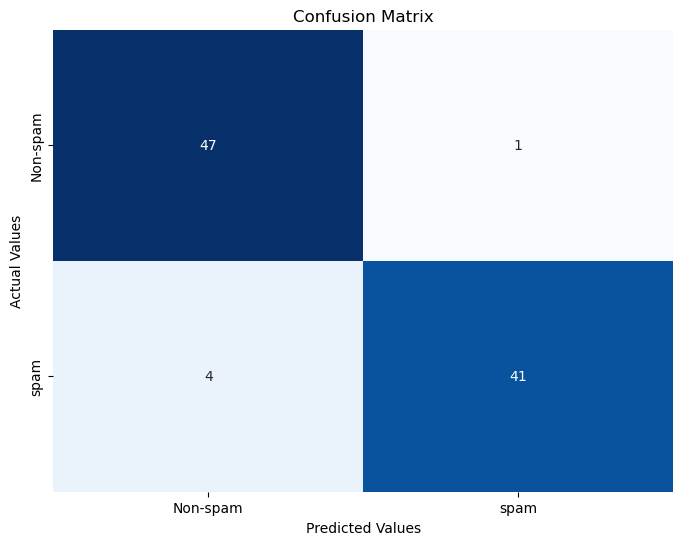

----------------------------
Accuracy: 0.95


In [14]:
# 10. Test the model on the test data, print the confusion matrix and the accuracy of the model.
y_pred = clf.predict(x_test_tfidf)

from sklearn.metrics import confusion_matrix, accuracy_score
conf_matrix = confusion_matrix(y_test, y_pred)
print("----------------------------")
print("Confusion Matrix: ")
print(conf_matrix)

import matplotlib.pyplot as plt
import seaborn as sns

labels=['Non-spam','spam'] # 0 = Non-spam, 1 = Spam
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

print("----------------------------")
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))

----------------------------
New Comments Predictions: [0 0 1 0 1 0 0 1 1 1 1 1 0 1 0 1 0 0]


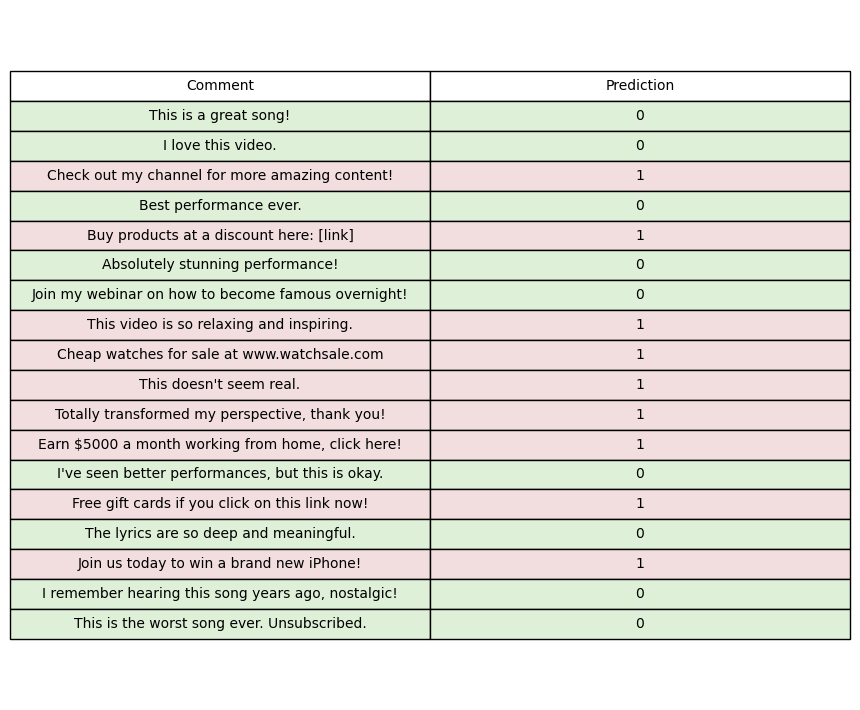

In [15]:
# Part 5
# 11. As a group come up with 6 new comments (4 comments should be non spam and 2 comment spam) and pass them to the classifier and check the results. You can be very creative and even do more
new_comments = [
   "This is a great song!",  
    "I love this video.",  
    "Check out my channel for more amazing content!",  
    "Best performance ever.",  
    "Buy products at a discount here: [link]",  
    "Absolutely stunning performance!",  
    "Join my webinar on how to become famous overnight!",  
    "This video is so relaxing and inspiring.",  
    "Cheap watches for sale at www.watchsale.com",  
    "This doesn't seem real.",  
    "Totally transformed my perspective, thank you!",  
    "Earn $5000 a month working from home, click here!",  
    "I've seen better performances, but this is okay.",  
    "Free gift cards if you click on this link now!",  
    "The lyrics are so deep and meaningful.",  
    "Join us today to win a brand new iPhone!",  
    "I remember hearing this song years ago, nostalgic!",  
    "This is the worst song ever. Unsubscribed.",  
]

# 12. Present all the results and conclusions.
new_comments_counts = count_vectorizer.transform(new_comments)
new_comments_tfidf = tfidf_transformer.transform(new_comments_counts)

new_predictions = clf.predict(new_comments_tfidf)
print("----------------------------")
print("New Comments Predictions:", new_predictions)


prediction_labels = ['Non-spam' if x == 0 else 'Spam' for x in new_predictions]

# Create a figure and a grid for the plot and the table
fig, ax = plt.subplots(figsize=(12, 10))  # Adjusted size for visibility
ax.axis('tight')
ax.axis('off')

# Prepare cell text by combining each comment with its prediction
cell_text = list(zip(new_comments, new_predictions))

# Create the table
the_table = ax.table(cellText=cell_text, colLabels=['Comment', 'Prediction'], cellLoc='center', loc='center')

# Coloring rows based on the prediction
colors = ['#dff0d8' if prediction == 'Non-spam' else '#f2dede' for prediction in prediction_labels]
for i, (color, (comment, prediction)) in enumerate(zip(colors, cell_text)):
    the_table[(i+1, 0)].set_facecolor(color)  # Coloring comment cells
    the_table[(i+1, 1)].set_facecolor(color)  # Coloring prediction cells

the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(1, 2)  # Adjust scale to space out the rows

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, top=0.8)

plt.show()